<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image blur

<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   7417      0 --:--:-- --:--:-- --:--:--  7417
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 91 kB/s 
     |████████████████████████████████| 1.0 MB 34.9 MB/s 
+ set +ex
Installation succeeded!


In [3]:
import numpy as np 
import cupy as cp 
from matplotlib import pyplot as plt
from PIL import Image

# image parameters
path = "logo.png"
size = 100
k = int(size / 100)
cmap = 'gray'
image = np.array(Image.open(path).resize((size, size)).convert('L'))

 
# kernel parameters
k_border = 2 * k
k_size = 2 * k_border + 1

# cupy and numpy kernels
np_kernel = np.ones((k_size,k_size)) # numpy kernel 
np_kernel /= np_kernel.sum() # normalize image values
cp_kernel = cp.array(np_kernel) # cupy kernel  

**Show initial image**

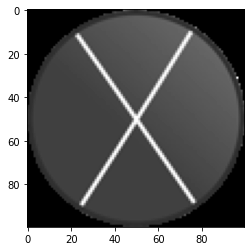

In [4]:
plt.imshow(image, cmap=cmap)

In [6]:
np_kernel.shape

(5, 5)

**Numpy and Cupy implementations**

In [7]:
# numpy implementation for bluring the image
def np_blur(parted_image, kernel):
    kernel = np.ravel(kernel) 
    out = np.dot(parted_image, kernel) 
    out = np.reshape(out, (size, size))
    return out

# cupy implementation for bluring the image
def cp_blur(parted_image, kernel):
    kernel = cp.ravel(kernel)
    out = cp.dot(parted_image, kernel)
    out = cp.reshape(out, (size, size))
    return out

# divide image into parts
def image_partitioning(img):
    np_parted_image = np.zeros((size * size, k_size * k_size), dtype='float32')
    for i in range(k_border, size - k_border):
        for j in range(k_border, size - k_border):
            np_parted_image[i * size + j] = img[i - k_border:i + k_border + 1, j - k_border:j + k_border + 1].flatten()
    return np_parted_image

**Do numpy and cupy blur**

In [8]:
# divide image into parts
np_parted_image = image_partitioning(image)
# same as numpy
cp_parted_image = cp.array(np_parted_image)

# apply numpy blur
np_blured = np_blur(np_parted_image, kernel = np_kernel)
# apply cupy blur
cp_blured = cp_blur(cp_parted_image, kernel = cp_kernel)

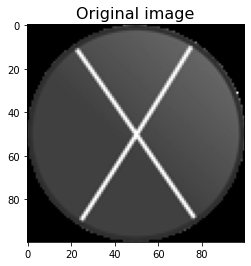

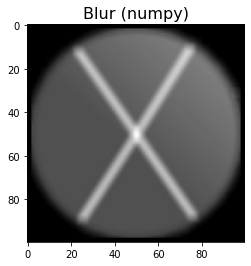

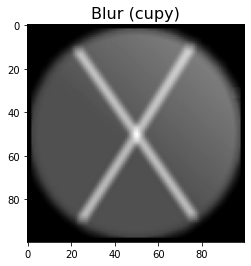

In [9]:
plt.title('Original image', fontsize=16)
plt.imshow(image, cmap = cmap)
plt.show()
plt.title('Blur (numpy)', fontsize=16)
plt.imshow(np_blured.astype(np.uint8), cmap = cmap)
plt.show()
plt.title('Blur (cupy)', fontsize=16)
plt.imshow(cp.asnumpy(cp_blured).astype(np.uint8), cmap = cmap)
plt.show()

**Cupy version computation time**

In [10]:
%timeit -n 10 cp_blur(cp_parted_image, cp_kernel)

10 loops, best of 5: 158 µs per loop


**Numpy version computation time**

In [11]:
%timeit -n 10 np_blur(np_parted_image, np_kernel)

10 loops, best of 5: 509 µs per loop


It may be seen that the cupy version allows to achieve faster performance 